# <center>Household Power Consumption Prediction<center/>

### Description 
This notebook implements a an sequential model from Household Power Consumption Prediction. Model input are measurements of electric power consumption. Data was gathered from one household with a one-minute sampling rate over a period of almost 4 years.

#### Data Set Information:

The dataset contains 2075259 samples/measurements gathered between December 2006 and November 2010 (47 months).<br>
**NOTE**: 
> (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

> The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

**Data Attributes Information:** 

1. date: Date in format dd/mm/yyyy

2. time: time in format hh:mm:ss

3. global_active_power: household global minute-averaged active power (in kilowatt)

4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5. voltage: minute-averaged voltage (in volt)

6. global_intensity: household global minute-averaged current intensity (in ampere)

7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner. <br>

#### Task : 
> Predict the power consumption measurements 

### Import necessary libraries 

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas_profiling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error

### Read data

In [0]:
data_path = "./foo.zip"
df = pd.read_csv(data_path, sep=';',parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'],index_col='dt')
df.drop(["Global_active_power","Global_reactive_power","Voltage","Global_intensity"],axis=1,inplace=True)

In [3]:
df.head()

,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,
2006-12-16 17:24:00,0.0,1.0,17.0
2006-12-16 17:25:00,0.0,1.0,16.0
2006-12-16 17:26:00,0.0,2.0,17.0
2006-12-16 17:27:00,0.0,1.0,17.0
2006-12-16 17:28:00,0.0,1.0,17.0


### Exploratory Data Analysis (optional)

In [0]:
# profile = pandas_profiling.ProfileReport(df)
# profile.to_file("report.html")
# profile

In [0]:
# df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum')
# #df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red')
# plt.tight_layout()
# plt.show()

### Preprocess Data
Fill NaN values by average, extract features from timestamps & normalize the data

In [0]:
#fill nan values with column average
for j in range(0,3):
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

#Data reshape for LSTM method
def reshape_for_lstm(df, lookback=1):
    l = len(df) - lookback
    X = df
    y = X[lookback:]
    res = []
    
    for i in range(l):
        res.append(X[i:i+lookback])
    return np.array(res), y

#Extract features from timestamp 
def features_from_timestamp(t):
    # h = t.hour
    # idx = np.searchsorted(list(range(3,25,3)),h,side='right')
    # interval = np.arange(3,25,3)[idx]
    # if  interval == 24 : interval = 0
    month = t.month
    season = (month in [11,12,1,2,3]) * 1 # 0: summer, 1:  winter
    return [t.day ,t.dayofweek, month  , season]

    # return [h,t.day ,t.dayofweek, month , interval , season]

# col = ["hour","day" ,"dayofweek", "month" , "interval" , "season"]
col = ["day" ,"dayofweek", "month" , "season"]

In [0]:
#Optional : Data can be grouped using timestamps by specific time i.e 1hr, 3hrs
# grouped_24h = df.groupby(pd.Grouper(freq='24h', base=0, label='right')).mean()

grouped_max = df.groupby(pd.Grouper(freq='24h', base=0, label='right')).max()
grouped_mean = df.groupby(pd.Grouper(freq='24h', base=0, label='right')).mean()
grouped_min = df.groupby(pd.Grouper(freq='24h', base=0, label='right')).min()
# list(data.columns)
# grouped_24h.head()

In [8]:
grouped_mean.rename(columns={"Sub_metering_1": "Sub_metering_1_mean","Sub_metering_2": "Sub_metering_2_mean",\
                     "Sub_metering_3": "Sub_metering_3_mean"},inplace=True)
grouped_max.rename(columns={"Sub_metering_1": "Sub_metering_1_max","Sub_metering_2": "Sub_metering_2_max",\
                     "Sub_metering_3": "Sub_metering_3_max"},inplace=True)
grouped_min.rename(columns={"Sub_metering_1": "Sub_metering_1_min","Sub_metering_2": "Sub_metering_2_min",\
                     "Sub_metering_3": "Sub_metering_3_min"},inplace=True)

data =  grouped_mean.merge(grouped_max,on='dt').merge(grouped_min,on='dt')
data.sort_index(inplace=True) #make sure data is sorted by date
data.tail()

,Sub_metering_1_mean,Sub_metering_2_mean,Sub_metering_3_mean,Sub_metering_1_max,Sub_metering_2_max,Sub_metering_3_max,Sub_metering_1_min,Sub_metering_2_min,Sub_metering_3_min
dt,,,,,,,,,
2010-11-23,3.371528,1.465278,7.038889,57.0,39.0,19.0,0.0,0.0,0.0
2010-11-24,1.299306,0.318056,5.285417,47.0,2.0,19.0,0.0,0.0,0.0
2010-11-25,0.761111,1.977778,8.488889,38.0,40.0,19.0,0.0,0.0,0.0
2010-11-26,0.747222,0.295833,3.522222,38.0,2.0,19.0,0.0,0.0,0.0
2010-11-27,0.855107,0.304830,7.908947,38.0,2.0,19.0,0.0,0.0,0.0


In [0]:
#Generate aditional features from timestamp then append to exixting data
# additional_featues = pd.DataFrame(data = [features_from_timestamp(i) for i in df.index ],columns=col).set_index(df.index)
# data = df.merge(additional_featues,on="dt")
# data.sort_index(inplace=True) #make sure data is sorted by date
# data.tail()

In [10]:
df.head()

,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,
2006-12-16 17:24:00,0.0,1.0,17.0
2006-12-16 17:25:00,0.0,1.0,16.0
2006-12-16 17:26:00,0.0,2.0,17.0
2006-12-16 17:27:00,0.0,1.0,17.0
2006-12-16 17:28:00,0.0,1.0,17.0


In [11]:
grouped_24h_sum = df.groupby(pd.Grouper(freq='24h', base=0, label='right')).sum()
grouped_24h_sum.head()

,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,
2006-12-17,0.0,546.0,4926.0
2006-12-18,2033.0,4187.0,13341.0
2006-12-19,1063.0,2621.0,14018.0
2006-12-20,839.0,7602.0,6197.0
2006-12-21,0.0,2648.0,14063.0


In [0]:
#Split data to train and test
test = data['2010-10-26':] #one month for testing
train = data[:'2010-10-26'] 

In [0]:
#Standardize the data
scaler = StandardScaler()
train = scaler.fit_transform(train.values)
test = scaler.transform(test.values)

In [0]:
#Prepare data for LSTM input
lookback = 5 #look back 5 days
Xtrain, ytrain = reshape_for_lstm(train,lookback)
Xtest, ytest = reshape_for_lstm(test,lookback)

In [15]:
Xtrain.shape

(1405, 5, 9)

### Define LSTM model

In [16]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM, Dropout, Dense

Using TensorFlow backend.


In [17]:
model = Sequential()
model.add(LSTM(5, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
# model.add(Dropout(0.2))
model.add(Dense(ytrain.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')

### Train Model

In [18]:
history = model.fit(Xtrain, ytrain, epochs=20, batch_size=32, validation_split=0.1,
                     verbose=1, shuffle=False)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1264 samples, validate on 141 samples
Epoch 1/20





1264/1264 [==============================] - 2s 1ms/step - loss: 0.8203 - val_loss: 2.8811
Epoch 2/20
1264/1264 [==============================] - 0s 351us/step - loss: 0.8023 - val_loss: 2.8757
Epoch 3/20
1264/1264 [==============================] - 0s 318us/step - loss: 0.7893 - val_loss: 2.8722
Epoch 4/20
1264/1264 [==============================] - 0s 349us/step - loss: 0.7774 - val_loss: 2.8694
Epoch 5/20
1264/1264 [==============================] - 0s 323us/step - loss: 0.7658 - val_loss: 2.8652
Epoch 6/20
1264/1264 [==============================] - 0s 352us/step - loss: 0.7538 - val_loss: 2.8568
Epoch 7/20
1264/1264 [==============================] - 1s 430us/step - loss: 0.7411 - val_loss: 2.8446
Epoch 8/20
1264/1264 [==============================] - 0s 372us/step - loss: 0.7278 - val_loss: 2.8299
Epoch 9/20
1264/1264 

### Plot Train loss

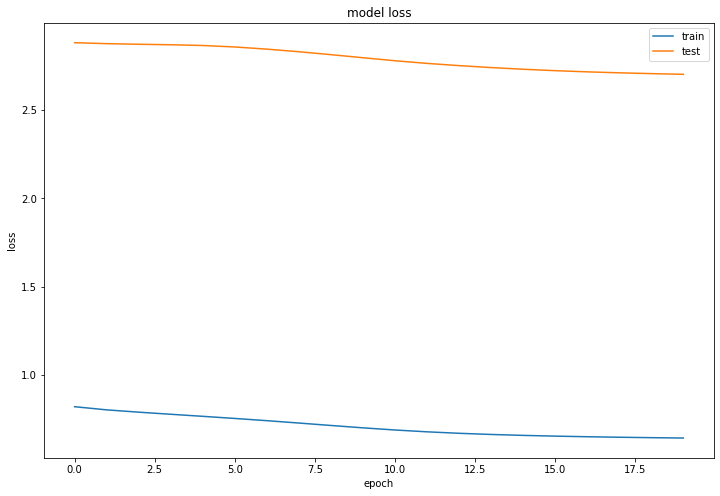

In [19]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(history.epoch,history.history['loss'])
plt.plot(history.epoch,history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Evaluate model Performance 

In [0]:
yhat = model.predict(Xtest)
mse = mean_squared_error(yhat,ytest)

In [21]:
print('MSE : {}'.format(mse))

MSE : 0.6045193304411219
